# 🗂️ Đề luyện giữa kỳ — BMI_CSV

**Chủ đề:** *Chỉ số BMI tổng hợp*

**Phần A:** Đọc dữ liệu, đặc trưng, trực quan hóa (matplotlib).

**Phần B:** Xác suất & phân vị (Nhị thức, Poisson, Chuẩn) + **khoảng tin cậy 90% cho tỷ lệ**.


In [7]:
# Thiết lập thư viện
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, norm
print('Ready')


Ready


## A1) Đọc dữ liệu & khám phá
**Yêu cầu:** in `head(5)`, `shape`, `dtypes`, số NA mỗi cột.

In [9]:
DATA_PATH = r"data/bmi.csv"
ext = os.path.splitext(DATA_PATH)[1].lower()
if ext in [".xls", ".xlsx"]:
    try:
        df = pd.read_excel(DATA_PATH)
    except Exception:
        try:
            df = pd.read_excel(DATA_PATH, engine="xlrd")
        except Exception:
            df = pd.read_excel(DATA_PATH, engine="openpyxl")
else:
    df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())
print('\nDtypes:'); print(df.dtypes)
print('\nMissing per column:'); print(df.isna().sum())


Shape: (500, 4)


,Personal,Gender,Height_cm,Weight_kg
0,P1,Male,174,96
1,P2,Male,189,87
2,P3,Female,185,110
3,P4,Female,195,104
4,P5,Male,149,61



Dtypes:
Personal     object
Gender       object
Height_cm     int64
Weight_kg     int64
dtype: object

Missing per column:
Personal     0
Gender       0
Height_cm    0
Weight_kg    0
dtype: int64


**Gợi ý lời giải:**
- `pd.read_excel` cho `.xls/.xlsx`; `.read_csv` cho `.csv`.
- Dùng `df.isna().sum()` để thống kê NA.


## A2) Làm sạch nhanh
- Chuẩn hóa `SEX/GENDER` (nếu có) → thêm cột `*_num` (M/Nam=1, F/Nữ=0)
- Chuyển cột object có dạng số ("1,200", "45%") sang số `_num`.

In [4]:
df = df.copy()
for col in df.columns:
    if str(col).strip().lower() in ('sex','gender'):
        df[col] = df[col].astype(str).str.strip().str.upper()
        mapping = {'M':1,'MALE':1,'NAM':1,'F':0,'FEMALE':0,'NU':0,'NỮ':0}
        df[col+'_num'] = df[col].map(mapping)

def to_num(s: pd.Series) -> pd.Series:
    return (s.astype(str)
              .str.replace(',','', regex=False)
              .str.replace('%','', regex=False)
              .str.replace(r'[^\d\.\+eE-]', '', regex=True)
              .str.strip()
              .pipe(pd.to_numeric, errors='coerce'))

df_num = df.select_dtypes(include='number').copy()
for c in df.select_dtypes(include='object').columns:
    cand = to_num(df[c])
    if cand.notna().sum() >= max(3, int(0.5*len(df))):
        df_num[c+'_num'] = cand
print('Numeric cols:', df_num.columns.tolist()[:10], '...')


Numeric cols: ['Height_cm', 'Weight_kg', 'Gender_num', 'Personal_num'] ...


**Gợi ý lời giải:**
- Dùng `select_dtypes(include='number')` để tránh lỗi tính mean trên cột chữ.
- Quy tắc nhận diện cột object có thể chuyển số: ≥ 50% phần tử chuyển được.

## A3) Đặc trưng thống kê
Tính: mean/median/std/min/max/count và `describe()` cho `df_num`.

In [5]:
stats_df = pd.DataFrame({
    'mean': df_num.mean(numeric_only=True),
    'median': df_num.median(numeric_only=True),
    'std': df_num.std(numeric_only=True),
    'min': df_num.min(numeric_only=True),
    'max': df_num.max(numeric_only=True),
    'count': df_num.count()
})
display(stats_df)
display(df_num.describe())


,mean,median,std,min,max,count
Height_cm,169.944,170.5,16.375261,140,199,500
Weight_kg,106.000,106.0,32.382607,50,160,500
Gender_num,0.490,0.0,0.500401,0,1,500
Personal_num,250.500,250.5,144.481833,1,500,500


,Height_cm,Weight_kg,Gender_num,Personal_num
count,500.000000,500.000000,500.000000,500.000000
mean,169.944000,106.000000,0.490000,250.500000
std,16.375261,32.382607,0.500401,144.481833
min,140.000000,50.000000,0.000000,1.000000
25%,156.000000,80.000000,0.000000,125.750000
50%,170.500000,106.000000,0.000000,250.500000
75%,184.000000,136.000000,1.000000,375.250000
max,199.000000,160.000000,1.000000,500.000000


**Gợi ý lời giải:**
- Nếu mean khác median nhiều → phân bố lệch, có thể có outlier.
- `std` lớn → dữ liệu phân tán mạnh.

## A4) Trực quan hóa (matplotlib)
- 1 histogram (cột số đầu tiên)
- 1 boxplot (≤10 cột số đầu)
- 1 scatter (2 cột số đầu)
- 1 heatmap tương quan

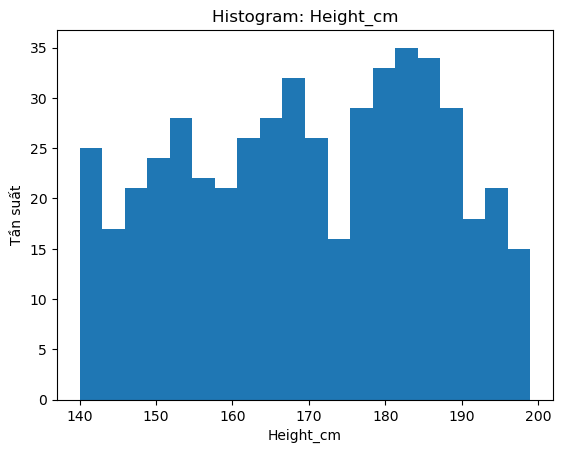

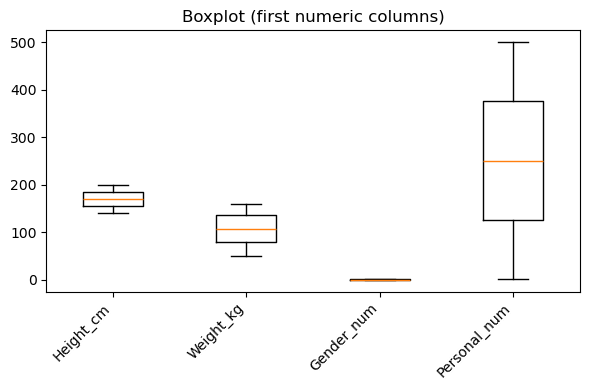

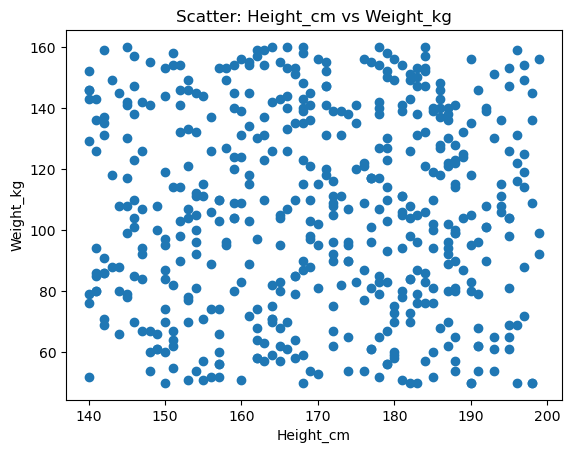

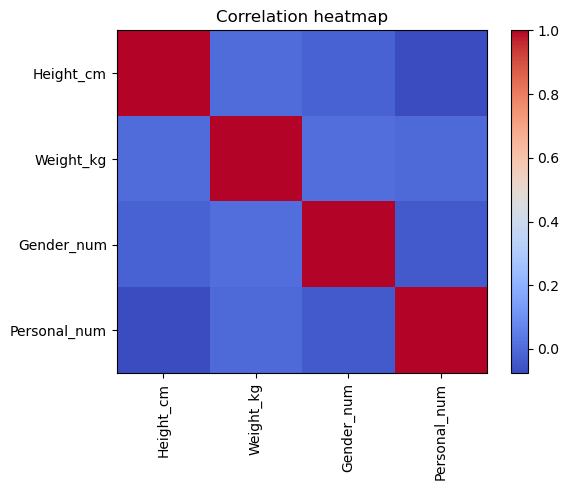

In [7]:
import matplotlib.pyplot as plt

num_cols = df_num.columns.tolist()

# Histogram
if num_cols:
    c = num_cols[0]
    plt.figure()
    plt.hist(df_num[c].dropna(), bins=20)
    plt.title(f'Histogram: {c}')
    plt.xlabel(c)
    plt.ylabel('Tần suất')
    plt.show()

# Boxplot
cols = num_cols[:10]
if cols:
    plt.figure(figsize=(max(6, 0.6*len(cols)), 4))
    # FIX: Đã thay 'labels' bằng 'tick_labels' để loại bỏ cảnh báo!
    plt.boxplot([df_num[x].dropna() for x in cols], tick_labels=cols, vert=True) 
    plt.title('Boxplot (first numeric columns)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Scatter
if len(num_cols) >= 2:
    x,y = num_cols[0], num_cols[1]
    plt.figure()
    plt.scatter(df_num[x], df_num[y])
    plt.title(f'Scatter: {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

# Heatmap
if len(num_cols) >= 2:
    # Thêm kiểm tra số lượng cột để tránh lỗi nếu num_cols quá ít cho heatmap lớn
    if len(num_cols) >= 2: 
        corr = df_num.corr(numeric_only=True)
        # Tối ưu kích thước heatmap cho dễ nhìn
        size = len(corr.columns)
        plt.figure(figsize=(max(6, 0.8 * size), max(5, 0.7 * size)))
        plt.imshow(corr, aspect='auto', cmap='coolwarm')
        plt.colorbar()
        plt.title('Correlation heatmap')
        plt.xticks(range(size), corr.columns, rotation=90)
        plt.yticks(range(size), corr.index)
        plt.tight_layout()
        plt.show()

**Gợi ý lời giải:**
- Histogram để nhìn phân bố; Boxplot để thấy outlier; Scatter để thấy tương quan; Heatmap để tổng quát tương quan.

## A5) Bài ngữ cảnh theo dataset
- Nếu có `SEX/GENDER`: so sánh trung bình biến số đầu theo giới; tính tỷ lệ một nhóm.
- Nếu có `BMIAP/BMISP`: tính tỷ lệ BMI giảm và **CI 90%** cho tỷ lệ.
- Nếu là đếm rời rạc (M&M): đặt bài **nhị thức/Poisson**.
- Nếu là đo lường liên tục (Voltage/Screws): đặt bài **Chuẩn**.

In [8]:
# SEX/GENDER group mean
sexcol=None
for c in df.columns:
    if str(c).strip().lower() in ('sex','gender'):
        sexcol=c; break
if sexcol and len(df_num.columns)>=1:
    g = df.groupby(sexcol)[df_num.columns[0]].mean(numeric_only=True)
    print('Group mean by', sexcol, 'for', df_num.columns[0])
    print(g)

# BMI decrease + CI90%
if set(['BMIAP','BMISP']).issubset(df.columns):
    n = len(df)
    x = (df['BMIAP'] < df['BMISP']).sum()
    p_hat = x/n if n else np.nan
    z = 1.645
    se = (p_hat*(1-p_hat)/n)**0.5 if n else np.nan
    print(f'[BMI decrease] {x}/{n} -> p̂={p_hat:.3f}, CI90%=({p_hat - z*se:.3f}, {p_hat + z*se:.3f})')


Group mean by Gender for Height_cm
Gender
FEMALE    170.227451
MALE      169.648980
Name: Height_cm, dtype: float64


**Gợi ý lời giải:**
- Tỷ lệ: `x/n`. CI90%: `p̂ ± 1.645 * sqrt(p̂(1-p̂)/n)`.
- Nhớ điều kiện xấp xỉ: `n p̂ ≥ 5` và `n(1-p̂) ≥ 5`.

## B) Xác suất & Phân vị — điền số theo ngữ cảnh đề
- **Nhị thức**: `binom.pmf/cdf/ppf`
- **Poisson**: `poisson.pmf/cdf/ppf`
- **Chuẩn**: `norm.cdf/ppf`

In [ ]:
# Binomial — TODO: điền n, p, k phù hợp ngữ cảnh
n, p, k = 10, 0.3, 3
print('[Binomial] P(X=k)=', binom.pmf(k,n,p), '  P(X<=k)=', binom.cdf(k,n,p), '  k_90=', binom.ppf(0.90,n,p))

# Poisson — TODO: điền λ phù hợp
lam = 6
print('[Poisson] P(X<=2)=', poisson.cdf(2,lam), '  P(X>=3)=', 1-poisson.cdf(2,lam), '  x_95%=', poisson.ppf(0.95,lam))

# Normal — TODO: điền μ, σ
mu, sigma = 100, 15
print('[Normal] P(X<120)=', norm.cdf(120,mu,sigma), '  P(85<X<115)=', norm.cdf(115,mu,sigma)-norm.cdf(85,mu,sigma), '  x_90%=', norm.ppf(0.90,mu,sigma))


**Gợi ý lời giải:**
- “ít nhất k” = `1 - binom.cdf(k-1, n, p)`; “không quá k” = `binom.cdf(k, n, p)`.
- Poisson: “≥ b” = `1 - poisson.cdf(b-1, λ)`.
- Normal: xác suất là diện tích → dùng `cdf` hoặc chênh 2 `cdf`.


**PHẦN C Xác suất & Phân vị**


**C.1 Nhị thức (Binomial)**

Ngữ cảnh mẫu: “Trong một mẫu n cá thể, xác suất một cá thể có tính chất A là p. Tính P(X = k), P(X ≤ k), phân vị 90%…”

Công cụ: binom.pmf (xác suất đúng k), binom.cdf (tích lũy), binom.ppf (phân vị).

In [3]:
from scipy.stats import binom

# TODO: điền tham số theo đề
n = 20      # cỡ mẫu
p = 0.35    # xác suất thành công của 1 cá thể
k = 7       # số thành công quan tâm

print("Binomial(n, p)")
print("P(X = k)   =", binom.pmf(k, n, p))
print("P(X <= k)  =", binom.cdf(k, n, p))
print("P(X >= k)  =", 1 - binom.cdf(k-1, n, p))
print("Phân vị 90% (k sao cho P(X <= k) >= 0.90):", binom.ppf(0.90, n, p))


Binomial(n, p)
P(X = k)   = 0.18440118638393138
P(X <= k)  = 0.6010266046031639
P(X >= k)  = 0.5833745817807674
Phân vị 90% (k sao cho P(X <= k) >= 0.90): 10.0


In [11]:
# --- BƯỚC 1: KIỂM TRA TÊN CỘT ---
print("Danh sách TÊN CỘT hiện tại trong DataFrame df:")
print(df.columns.tolist())

# --- BƯỚC 2: CHỌN VÀ SỬA (Giả định tên cột đúng là 'body_mass_g') ---
# Nếu thấy tên cột có khoảng trắng: ví dụ 'body_mass_g '
# Hoặc nếu thấy tên cột có ký tự khác: ví dụ 'Body_Mass_g'
# Cậu cần sửa lại tên trong code của cậu

Danh sách TÊN CỘT hiện tại trong DataFrame df:
['Personal', 'Gender', 'Height_cm', 'Weight_kg']


In [10]:
# Ví dụ: A = "chim có body_mass_g > 5000"
p_hat = (df['body_mass_g'] > 5000).mean()
n = 30; k = 10
print("Dùng p̂ từ dữ liệu:", p_hat)
print("P(X = k) với p̂   =", binom.pmf(k, n, p_hat))


KeyError: 'body_mass_g'